# Repoerting MNI/PPMI/ADNI data demographics and initial test for L2 based matching
This is the notebook for dataset demographics visualziation and choosing the propor testing the matching the control subjects with our ET subjects to creat new subsamples that is 
## Data: 
    - 1. MNI demographics:   ./tab_data/freesurfer_out_preped.csv
    - 2. PPMI demographics:  ./tab_data/3T_T1_NC_PPMI_5_08_2021.csv
    - 3. ADNI2 demographics: ./tab_data/3T_T1_CN_ADNI2_7_15_2021.csv
## Cohorts
- Current cohort: MNI ET/NC (38/32), PPMI NC (116) and ADNI NC(312), before QC.

## Tasks
    - 1. Visualziation for demographics;
    - 2. Initial test for L2 based matching methods;


PPMI NC subjects from  2010  to  2018


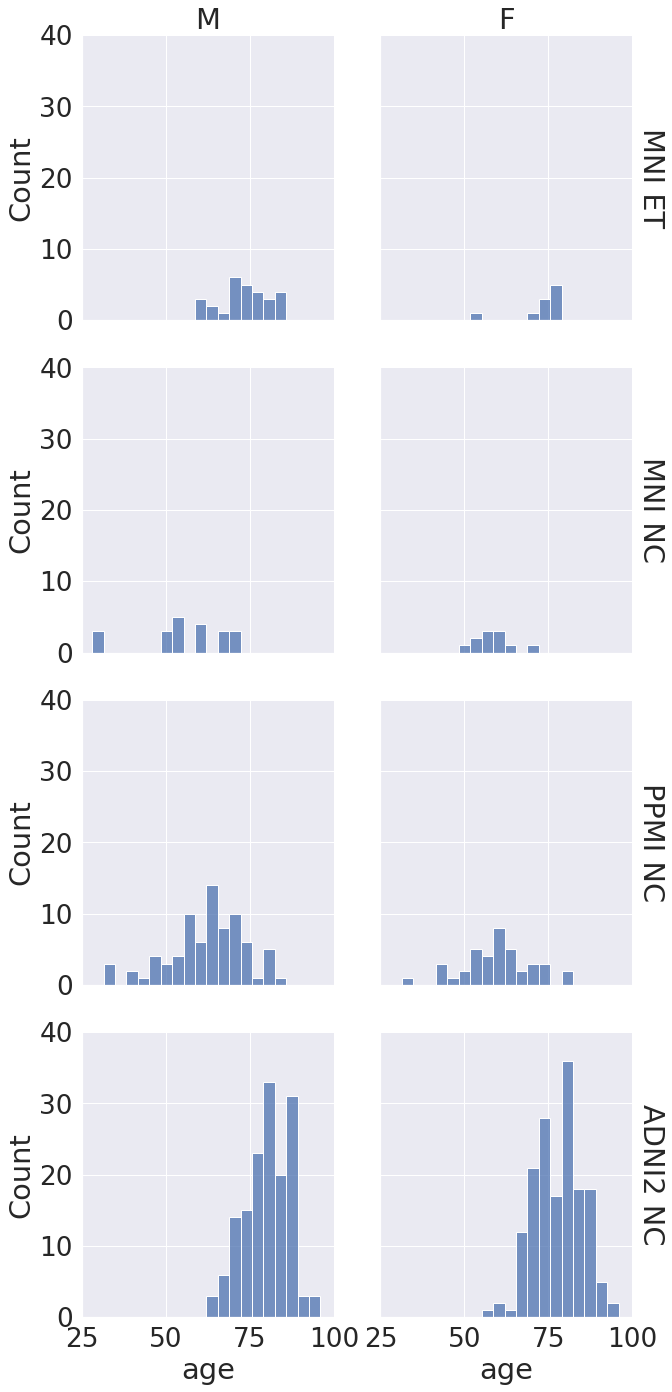

In [1]:
## Preproc PPMI and NC tab
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
mni_file = data_dir/'freesurfer_out_preped.csv'
ppmi_file = data_dir/'3T_T1_NC_PPMI_5_08_2021.csv'
adni_file = data_dir/'ADNIMERGE_Nikhil.csv'
adni2_file = data_dir/'3T_T1_CN_ADNI2_7_15_2021.csv'

# MNI ET dataset preproc
mni_tab  = pd.read_csv(mni_file, sep=',', header=0, index_col=0)
mni_tab['subject']=mni_tab.index
mni_nc_tab  = mni_tab[mni_tab['diagnosis']=='NC'][['age', 'sex', 'subject']]; mni_nc_tab['group']='MNI NC'
mni_et_tab  = mni_tab[mni_tab['diagnosis']=='ET'][['age', 'sex', 'subject']]; mni_et_tab['group']='MNI ET'
# PPMI NC prepproc
ppmi_tab = pd.read_csv(ppmi_file, sep=',', header=0, index_col=0)
# PPMI aquisition time span
ppmi_tab['acq_year']=ppmi_tab['Acq Date'].apply(lambda x: int(x[-4:]))
print('PPMI NC subjects from ', min(ppmi_tab['acq_year']), ' to ', max(ppmi_tab['acq_year']))
# take the most recent visit and remove duplicates
ppmi_tab['visit_last'] = ppmi_tab.groupby(['Subject'])['Visit'].transform(max)
ppmi_tab = ppmi_tab[ppmi_tab['Visit']==ppmi_tab['visit_last']]
ppmi_tab.sort_values(by='Subject', ascending=False)
ppmi_tab['duplicate']=ppmi_tab['Subject'].duplicated()
# detailed duplicate information
#display(ppmi_tab[ppmi_tab['duplicate']==True])
#display(ppmi_tab[ppmi_tab['Subject']==4085])
#display(ppmi_tab[ppmi_tab['Subject']==3571])
#display(ppmi_tab[ppmi_tab['Subject']==3551])
#display(ppmi_tab[ppmi_tab['Subject']==3361])
# manully remove the duplicates with same subject ID and visit number.
ppmi_tab=ppmi_tab.drop(['I864811', 'I864810','I615265','I548986','I581043']) 
ppmi_nc_tab = ppmi_tab[['Age','Sex']]
ppmi_nc_tab = ppmi_nc_tab.rename(columns=str.lower); ppmi_nc_tab['group']='PPMI NC'
ppmi_nc_tab['subject']=ppmi_nc_tab.index
ppmi_nc_tab=ppmi_nc_tab.drop_duplicates(subset=['subject']);

# preproc ANDI tab (updated from 15th July 2021 downloaded version)
adni2_tab = pd.read_csv(adni2_file, sep=',', header=0, index_col=0)
# select cohort
# select the normal control
adni2_nc_tab = adni2_tab[['Subject', 'Age', 'Group', 'Sex','Visit', 'Description']]
adni_nc_tab=adni2_nc_tab.rename(str.lower, axis='columns')
adni_nc_tab['visit_last'] = adni_nc_tab.groupby(['subject'])['visit'].transform(max)
adni_nc_tab = adni_nc_tab[adni_nc_tab['visit']==adni_nc_tab['visit_last']]
# remove dubplicate sessions
adni_nc_tab=adni_nc_tab.drop_duplicates(subset=['subject'])
adni_nc_tab=adni_nc_tab.drop_duplicates(subset=['subject','description']);
adni_nc_tab['group']='ADNI2 NC'
data_tab = pd.concat([mni_et_tab, mni_nc_tab, ppmi_nc_tab, adni_nc_tab], ignore_index=True)

# plot disctribution
from matplotlib import pyplot
SEX_ORDER=['M','F']; GROUP_ORDER=['MNI ET','MNI NC','PPMI NC','ADNI2 NC']
LIM_AGE=(25, 100); LIM_CNT=(0, 40); 

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="darkgrid")
sns.set(font_scale=2.4)
dist_plt=sns.displot(data_tab, x="age", row='group', col='sex', 
                     facet_kws=dict(margin_titles=True),
                     row_order=GROUP_ORDER, col_order=SEX_ORDER)
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")
dist_plt.set(ylim=LIM_CNT); dist_plt.set(xlim=LIM_AGE); 
#fig = dist_plt.get_figure()
dist_plt.savefig("/codes/pre-registration/demographics.jpg", dpi=300)
#data_tab

In [10]:
# Report cohort statsitics:
print('MNI: mean~std')
print(mni_tab.age.mean(), '~' ,mni_tab.age.std() )
print('MNI ET: m~std')
print(mni_et_tab.age.mean(), '~' ,mni_et_tab.age.std() )
print('MNI NC: m~std')
print(mni_nc_tab.age.mean(), '~' ,mni_nc_tab.age.std() )
print('PPMI NC:')
print(ppmi_nc_tab.age.mean(), '~' , ppmi_nc_tab.age.std() )
print('ADNI2 NC:')
print(adni_nc_tab.age.mean(), '~' , adni_nc_tab.age.std() )

MNI: mean~std
64.24107142857143 ~ 11.246817796755249
MNI ET: m~std
73.39473684210526 ~ 6.9653174533666125
MNI NC: m~std
56.3125 ~ 11.093262994762531
PPMI NC:
61.23931623931624 ~ 11.101141268332523
ADNI2 NC:
73.39572192513367 ~ 6.263495785034133


In [2]:
# comparison of distributions
def distr_test(g1, g2):
    import scipy
    import statsmodels.stats.weightstats as ws
    # group are dataframes with M/F as sex and int as age
    g1_name=list(g1['group'])[0]; g2_name= list(g2['group'])[0];
    g1_m = g1[g1['sex']=='M'].shape[0]; g1_f = g1[g1['sex']=='F'].shape[0];
    g2_m = g2[g2['sex']=='M'].shape[0]; g2_f = g2[g2['sex']=='F'].shape[0];
    print( g1_name, '/', g2_name,' :')
    print('M/F: ', g1_m, '/', g1_f, '; ', g2_m, '/', g2_f)
    print('age mean: ', g1['age'].mean(),  '/', g2['age'].mean())
    print('age std: ',  g1['age'].std(), '/'  , g2['age'].std())
    # chi-square test for sex
    chisq, chi_pval = scipy.stats.chi2_contingency([[g1_m, g1_f], [g2_m, g2_f]])[:2]
    print('Sex Chisqure test: \n','chisq =%.6f, pvalue = %.6f'%(chisq, chi_pval));
    # t-test for age 
    t_stat,t_pval,t_df=ws.ttest_ind(g1['age'], g2['age'], alternative='two-sided', usevar='pooled')
    print('Age 2-sided independent t-test (tstat, pval, df): \n','tstat =%.6f, pvalue = %.6f, df = %i'%(t_stat, t_pval, t_df),'\n\n')
    return

# report
distr_test(data_tab[data_tab['group']=='MNI ET'], data_tab[data_tab['group']=='MNI NC'])
distr_test(data_tab[data_tab['group']=='MNI ET'], data_tab[data_tab['group']=='PPMI NC'])
distr_test(data_tab[data_tab['group']=='MNI ET'], data_tab[data_tab['group']=='ADNI2 NC'])

MNI ET / MNI NC  :
M/F:  28 / 10 ;  21 / 11
age mean:  73.39473684210526 / 56.3125
age std:  6.9653174533666125 / 11.093262994762531
Sex Chisqure test: 
 chisq =0.222039, pvalue = 0.637490
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =7.838579, pvalue = 0.000000, df = 68 


MNI ET / PPMI NC  :
M/F:  28 / 10 ;  78 / 39
age mean:  73.39473684210526 / 61.23931623931624
age std:  6.9653174533666125 / 11.101141268332523
Sex Chisqure test: 
 chisq =0.369102, pvalue = 0.543494
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =6.348213, pvalue = 0.000000, df = 153 


MNI ET / ADNI2 NC  :
M/F:  28 / 10 ;  151 / 161
age mean:  73.39473684210526 / 78.85576923076923
age std:  6.9653174533666125 / 6.9796464811075305
Sex Chisqure test: 
 chisq =7.686037, pvalue = 0.005565
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =-4.554819, pvalue = 0.000007, df = 348 




# matching problems:
1. What should we do if we have enough matched subjects but not for each sex, by now I just include to the total number we need;
2. Lacking the Maximum Mean Discrepancy (distance distribution) based methods
https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution
https://www.youtube.com/watch?v=mm7bHjEzhow
https://www.youtube.com/watch?v=fFrhvrGg9hw
https://arxiv.org/abs/2010.11415
https://arxiv.org/pdf/1906.05944.pdf
3. matching distribution
https://link.springer.com/chapter/10.1007/978-3-319-58347-1_5
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5378668/
https://journals.lww.com/epidem/Abstract/2017/05000/Matching_Weights_to_Simultaneously_Compare_Three.13.aspx


In [3]:
# matching by percentile
import numpy as np
import math

nc_needed=116; 
mni_et_m = len(mni_et_tab[mni_et_tab['sex']=='M']); mni_et_f = len(mni_et_tab[mni_et_tab['sex']=='F']);
nc_m_needed=round(nc_needed*(mni_et_m/(mni_et_m+mni_et_f))); 
nc_f_needed=round(nc_needed*(mni_et_f/(mni_et_m+mni_et_f))); 

def age2percentile(age_array):
    import numpy as np
    percentiles = np.argsort(np.argsort(age_array)) * 100. / (len(age_array) - 1)
    return percentiles

def dist_score_L2(age, group_age):
    #group_size = len(group_age);
    score=np.sqrt(sum(np.power(group_age-age,2)))
    return score

def distr_match(distr_target, n_target, distr_source, match_method, para):
    #inlcuding all the subjects within the percentile of target distribution,
    import pandas as pd
    # parameters resolve
    percent_th = para['percentile']; percent_th_c = 100-para['percentile'];
    ## default 
    res=distr_source;
    distr_target_m = distr_target[distr_target['sex']=='M']; distr_target_f=distr_target[distr_target['sex']=='F'];
    distr_source_m = distr_source[distr_source['sex']=='M']; distr_source_f=distr_source[distr_source['sex']=='F'];
    n_target_m = round(nc_needed*len(distr_target_m)/(len(distr_target)));  n_target_f = nc_needed-n_target_m;
    target_m_mean = distr_target_m['age'].mean(); target_m_std = distr_target_m['age'].std();
    target_f_mean = distr_target_f['age'].mean(); target_f_std = distr_target_f['age'].std(); 
    print('Expecting ',n_target_m,' M and ',n_target_f,'F')
    
    ## differenct methods
    if match_method=='percentile':
        # get percentile thresholds by sex
        th_m_lower = np.percentile(distr_target_m['age'], percent_th); th_m_higher = np.percentile(distr_target_m['age'], percent_th_c);
        th_f_lower = np.percentile(distr_target_f['age'], percent_th); th_f_higher = np.percentile(distr_target_f['age'], percent_th_c); 
        res_m_sel=distr_source_m[(distr_source_m['age']>=th_m_lower)&(distr_source_m['age']<=th_m_higher)];
        res_f_sel=distr_source_f[(distr_source_f['age']>=th_f_lower)&(distr_source_f['age']<=th_f_higher)];
        res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
        n_matched_m = len(res_m_sel); n_matched_f = len(res_f_sel);
        print('Percentile matching with percentile=', percent_th, ' , and get ', len(res_sel), ' matched subjects.')
        if n_target_m <= n_matched_m:
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more = n_target_f-n_matched_f;
                res_m_sel2 = res_m_sel.sample(n=(n_target_m+n_more), random_state=1);
                res_sel = pd.concat([res_m_sel2, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel2), '/', len(res_f_sel) )
                return res_sel
        else:
            if n_target_f <= n_matched_f:
                n_more = n_matched_f-n_target_f;
                res_f_sel1 = res_f_sel.sample(n=n_target_f+n_more, random_state=1);
                res_sel = pd.concat([res_m_sel, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel1) )
                return res_sel
            else:
                res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel) )
                print('Fail to get enough matched subjects!')
                return res_sel
    elif match_method=='target_mean':
        distr_source_m['target_score'] = (distr_source_m['age']-target_m_mean)/target_m_std;
        distr_source_f['target_score'] = (distr_source_f['age']-target_f_mean)/target_f_std;
        distr_source_m['percentile'] = age2percentile(distr_source_m['target_score']); 
        distr_source_f['percentile'] = age2percentile(distr_source_f['target_score']);
        res_m_sel=distr_source_m[(distr_source_m['percentile']>=percent_th)&(distr_source_m['percentile']<=percent_th_c)];
        res_f_sel=distr_source_f[(distr_source_f['percentile']>=percent_th)&(distr_source_f['percentile']<=percent_th_c)];
        res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
        n_matched_m = len(res_m_sel); n_matched_f = len(res_f_sel);
        print('Percentile based on ET mean matching with percentile=', percent_th, ' , and get ', len(res_sel), ' matched subjects.')
        if n_target_m <= n_matched_m:
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more = n_target_f-n_matched_f;
                res_m_sel2 = res_m_sel.sample(n=(n_target_m+n_more), random_state=1);
                res_sel = pd.concat([res_m_sel2, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel2), '/', len(res_f_sel) )
                return res_sel
        else:
            if n_target_f <= n_matched_f:
                n_more = n_matched_f-n_target_f;
                res_f_sel1 = res_f_sel.sample(n=n_target_f+n_more, random_state=1);
                res_sel = pd.concat([res_m_sel, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel1) )
                return res_sel
            else:
                res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel) )
                print('Fail to get enough matched subjects!')
                return res_sel
    elif match_method=='l2_cut':
        age_tar_m=distr_target_m['age'];  age_tar_f=distr_target_f['age'];
        distr_source_m['L2_score'] = distr_source_m['age'].map(lambda x: dist_score_L2(x, age_tar_m));
        distr_source_f['L2_score'] = distr_source_f['age'].map(lambda x: dist_score_L2(x, age_tar_f));
        th_m_cut = np.percentile(distr_source_m['age'], percent_th_c);  th_f_cut = np.percentile(distr_source_f['age'], percent_th_c);
        res_m_sel=distr_source_m[distr_source_m['L2_score']<th_m_cut]; res_f_sel=distr_source_f[distr_source_f['L2_score']<th_f_cut];
        res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
        n_matched_m = len(res_m_sel); n_matched_f = len(res_f_sel);
        print('L2-cut based matching with cut_percent=', percent_th, ' , and get ', len(res_sel), ' matched subjects.')
        if n_target_m <= n_matched_m:
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more = n_target_f-n_matched_f;
                res_m_sel2 = res_m_sel.sample(n=(n_target_m+n_more), random_state=1);
                res_sel = pd.concat([res_m_sel2, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel2), '/', len(res_f_sel) )
                return res_sel
        else:
            if n_target_f <= n_matched_f:
                n_more = n_matched_f-n_target_f;
                res_f_sel1 = res_f_sel.sample(n=n_target_f+n_more, random_state=1);
                res_sel = pd.concat([res_m_sel, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel1) )
                return res_sel
            else:
                res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel) )
                print('Fail to get enough matched subjects!')
                return res_sel
    elif match_method=='new_method':
        pass
    else:
        print(match_method, ' is not supported yet!!!')
    return res
####

## use
para={'percentile':5}
#match
percentile_matched=distr_match(data_tab[data_tab['group']=='MNI ET'], nc_needed, data_tab[data_tab['group']=='ADNI2 NC'], 'l2_cut', para)
# test
distr_test(data_tab[data_tab['group']=='MNI ET'], percentile_matched)
#percentile_matched
percentile_matched_all=distr_match(data_tab[data_tab['group']=='MNI ET'], nc_needed, data_tab[data_tab['group']!='MNI ET'], 'l2_cut', para)
# test
distr_test(data_tab[data_tab['group']=='MNI ET'], percentile_matched_all)
# report other stats of the disctribution...

Expecting  85  M and  31 F
L2-cut based matching with cut_percent= 5  , and get  300  matched subjects.
Get matched M/F:  85 / 31
MNI ET / ADNI2 NC  :
M/F:  28 / 10 ;  85 / 31
age mean:  73.39473684210526 / 79.16379310344827
age std:  6.9653174533666125 / 6.659343178888807
Sex Chisqure test: 
 chisq =0.026249, pvalue = 0.871293
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =-4.582695, pvalue = 0.000010, df = 152 


Expecting 

/tmp/ipykernel_649/1433158858.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distr_source_m['L2_score'] = distr_source_m['age'].map(lambda x: dist_score_L2(x, age_tar_m));
/tmp/ipykernel_649/1433158858.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distr_source_f['L2_score'] = distr_source_f['age'].map(lambda x: dist_score_L2(x, age_tar_f));


 85  M and  31 F
L2-cut based matching with cut_percent= 5  , and get  406  matched subjects.
Get matched M/F:  85 / 31
MNI ET / PPMI NC  :
M/F:  28 / 10 ;  85 / 31
age mean:  73.39473684210526 / 73.44827586206897
age std:  6.9653174533666125 / 8.231799240787502
Sex Chisqure test: 
 chisq =0.026249, pvalue = 0.871293
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =-0.036066, pvalue = 0.971277, df = 152 




/tmp/ipykernel_649/1433158858.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distr_source_m['L2_score'] = distr_source_m['age'].map(lambda x: dist_score_L2(x, age_tar_m));
/tmp/ipykernel_649/1433158858.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distr_source_f['L2_score'] = distr_source_f['age'].map(lambda x: dist_score_L2(x, age_tar_f));


/tmp/ipykernel_649/1107797694.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mni_nc_m['L2_score']=mni_nc_m['age'].map(lambda x: dist_score_L2(x, age_et_m))
/tmp/ipykernel_649/1107797694.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mni_nc_f['L2_score']=mni_nc_f['age'].map(lambda x: dist_score_L2(x, age_et_f))
/tmp/ipykernel_649/1107797694.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

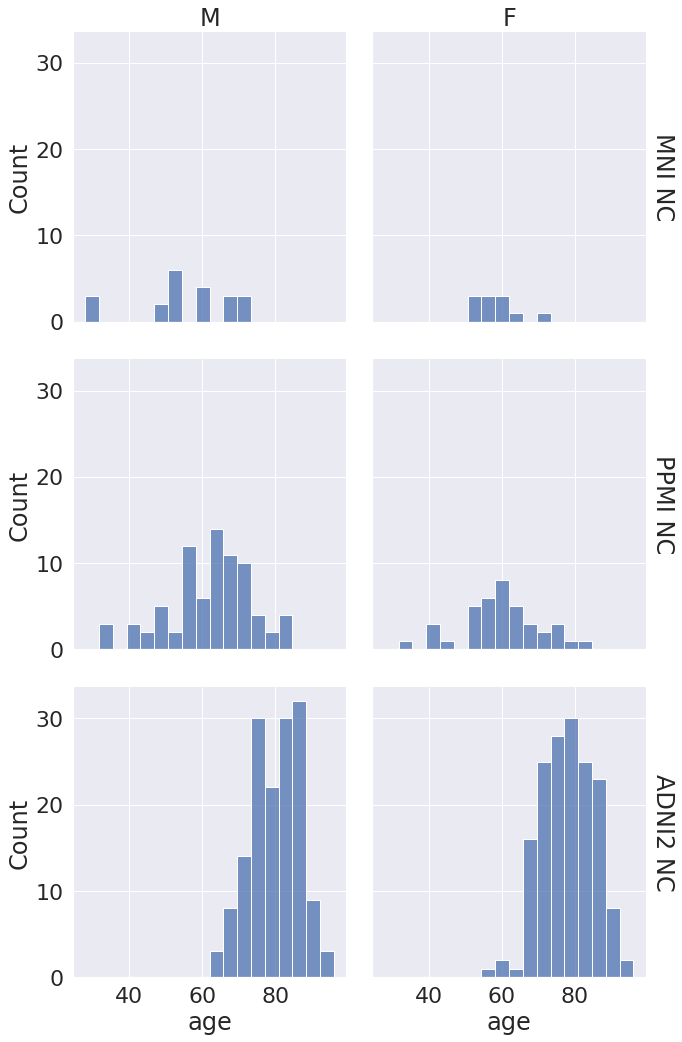

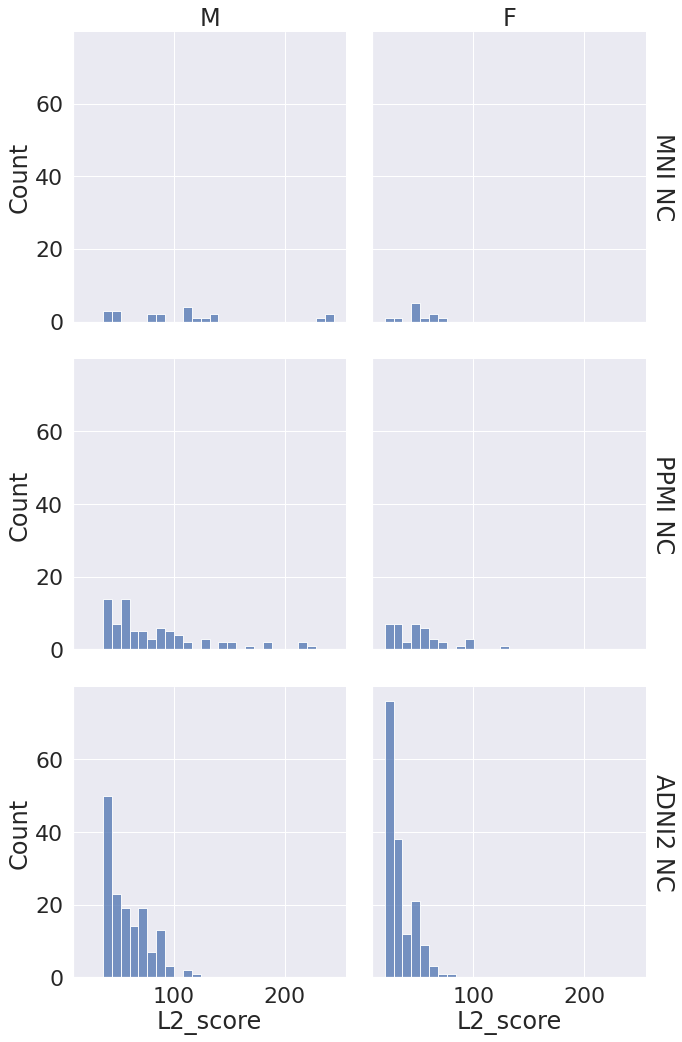

In [4]:
# L1 and L2 distance matching
# should we match by 
def dist_score_L2(age, group_age):
    #group_size = len(group_age);
    score=np.sqrt(sum(np.power(group_age-age,2)))
    return score
# test: dist_score_L2(10, mni_et_tab['age'])
age_et=mni_et_tab['age']; 
age_et_m=mni_et_tab[mni_et_tab['sex']=='M']['age']; 
age_et_f=mni_et_tab[mni_et_tab['sex']=='F']['age'];
mni_nc_m=mni_nc_tab[mni_nc_tab['sex']=='M']; mni_nc_f=mni_nc_tab[mni_nc_tab['sex']=='F']
ppmi_nc_m=ppmi_nc_tab[ppmi_nc_tab['sex']=='M']; ppmi_nc_f=ppmi_nc_tab[ppmi_nc_tab['sex']=='F'];
adni_nc_m=adni_nc_tab[adni_nc_tab['sex']=='M']; adni_nc_f=adni_nc_tab[adni_nc_tab['sex']=='F'];
#
mni_nc_m['L2_score']=mni_nc_m['age'].map(lambda x: dist_score_L2(x, age_et_m))
mni_nc_f['L2_score']=mni_nc_f['age'].map(lambda x: dist_score_L2(x, age_et_f))
ppmi_nc_m['L2_score']=ppmi_nc_m['age'].map(lambda x: dist_score_L2(x, age_et_m))
ppmi_nc_f['L2_score']=ppmi_nc_f['age'].map(lambda x: dist_score_L2(x, age_et_f))
adni_nc_m['L2_score']=adni_nc_m['age'].map(lambda x: dist_score_L2(x, age_et_m))
adni_nc_f['L2_score']=adni_nc_f['age'].map(lambda x: dist_score_L2(x, age_et_f))
l2_matched_nc = pd.concat([mni_nc_m, mni_nc_f, ppmi_nc_m, ppmi_nc_f,adni_nc_m, adni_nc_f])

# plot
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
dist_plt=sns.displot(l2_matched_nc, x="age", row="group", col='sex',
                     facet_kws=dict(margin_titles=True),
                     col_order=SEX_ORDER, row_order=['MNI NC','PPMI NC','ADNI2 NC'])
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")
#dist_plt.set(ylim=LIM_CNT); dist_plt.set(xlim=LIM_AGE); 
dist_plt=sns.displot(l2_matched_nc, x="L2_score", row="group", col='sex',
                     facet_kws=dict(margin_titles=True),
                     col_order=SEX_ORDER, row_order=['MNI NC','PPMI NC','ADNI2 NC'])
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")

In [5]:
# preproc ANDI tab from ADNIMERGE.csv (Expired, not used any more )
adni_tab = pd.read_csv(adni_file, sep=',', header=0, index_col=0)
display('All ADNI2 subjects types:')
display(adni_tab['DX_bl'].unique())
# select cohort
adni_tab = adni_tab[adni_tab['ORIGPROT']=='ADNI2']
# select the normal control
adni_nc_tab = adni_tab[adni_tab['DX_bl']=='CN']
adni_nc_tab[['subject', 'age', 'group', 'sex','visit']] = adni_nc_tab[['PTID', 'AGE', 'ORIGPROT', 'PTGENDER','VISCODE']]
def trans_visit_adni(x):
    if x=='m03': return 3;
    elif x=='m06': return 6; 
    elif x=='m12': return 12;
    elif x=='m18': return 18;
    elif x=='m24': return 24;
    elif x=='m30': return 30;
    elif x=='m36': return 36;
    elif x=='bl': return 0;
    else: return -1;
def trans_sex_adni(x):
    if x=='Male': return 'M';
    elif x=='Female': return 'F';
adni_nc_tab['visit']=adni_nc_tab['VISCODE'].apply(lambda x: trans_visit_adni(x))
adni_nc_tab['sex']=adni_nc_tab['PTGENDER'].apply(lambda x: trans_sex_adni(x))
adni_nc_tab['visit_last'] = adni_nc_tab.groupby(['PTID'])['visit'].transform(max)
adni_nc_tab = adni_nc_tab[adni_nc_tab['visit']==adni_nc_tab['visit_last']]
adni_nc_tab['subject']=adni_nc_tab['PTID']; adni_nc_tab['age']=adni_nc_tab['AGE']; adni_nc_tab['group']=adni_nc_tab['ORIGPROT'];
adni_nc_tab=adni_nc_tab[['subject','age','sex','group']]; adni_nc_tab['group']='ADNI2 NC'
data_tab = pd.concat([mni_et_tab, mni_nc_tab, ppmi_nc_tab, adni_nc_tab],ignore_index=True)

'All ADNI2 subjects types:'

array(['CN', 'AD', 'LMCI', 'EMCI', 'SMC'], dtype=object)

/usr/local/miniconda/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/tmp/ipykernel_649/1433540843.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adni_nc_tab['visit']=adni_nc_tab['VISCODE'].apply(lambda x: trans_visit_adni(x))
/tmp/ipykernel_649/1433540843.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 